# Define Threshold for Photon Counting Mode (03/04/2025)
We want to measure the molecule fluorescence using the photon counting mode of the EMCCD camera. We need to get a threshold that determines whether photon detected =0 or =1. Details can be found in this link:
https://www.nuvucameras.com/photon-counting/ [Ref 1]

From OneNote: dark counts do not matter at exposure time of 15-30ms.
(What is the exposure time for 10MHz rate?)

A typical AD counts of EMCCD pixels is shown below:
<div>
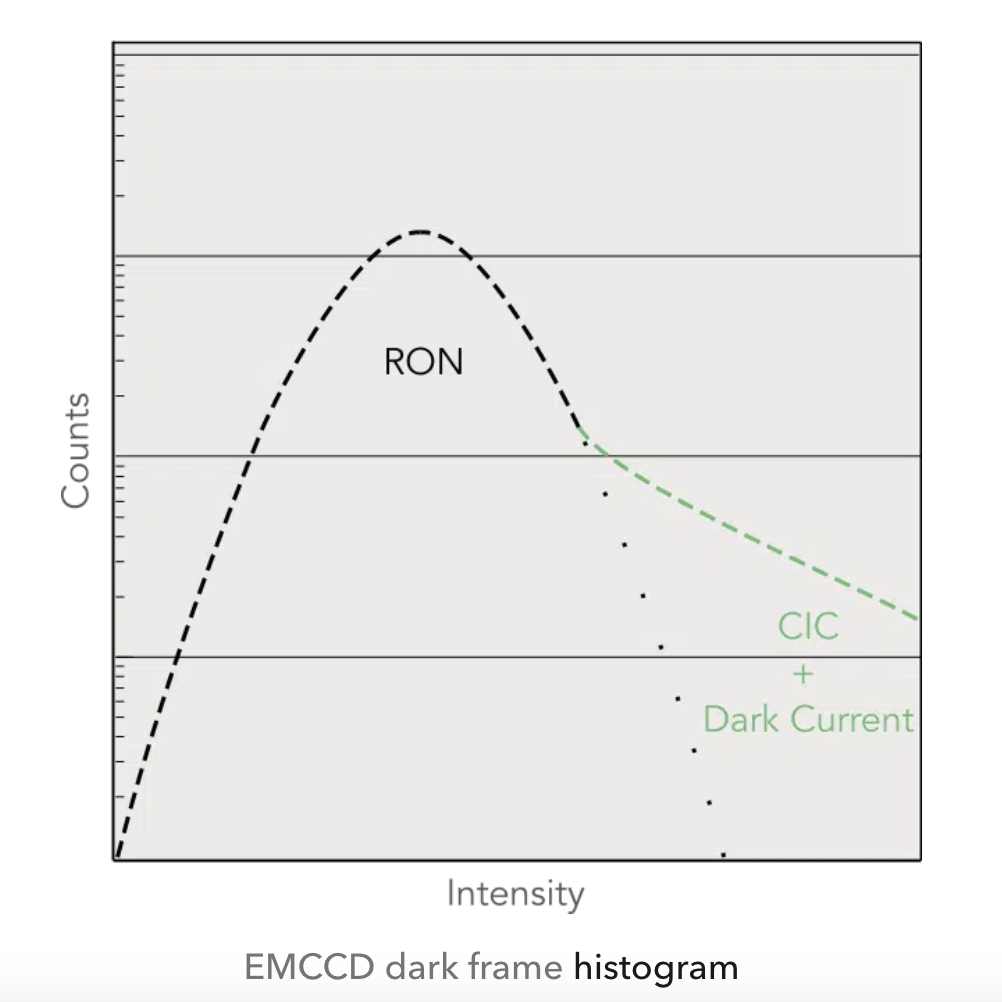
</div>

The ReadOut Noise is Gaussian. CIC/dark current noise can be modeled as an exponential random variable distribution.

# How to define threshold
Method: From the gaussian fit we get the std $\sigma$. (Note that it is a Gaussian in linear scale and not a Gaussian in log scale..)

For EMCCDs, a universally recognized interval of confidence is achieved with a 5$\sigma$ threshold[1]. 

A normalized Gaussian distribution is as follows:

$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

Just for reference, the probability that values lie within 1-5 $\sigma$ of the mean is

1$\sigma$ = 68.3%

2$\sigma$ = 95.5%

3$\sigma$ = 99.73%

4$\sigma$ = 99.994%

5$\sigma$ = 99.99994%

Best threshold? - Setting a threshold to larger than necessary means throwing away signal data, whereas setting it smaller than necessary makes SNR worse (Note that noise gets exponentially larger as threshold goes below 3$\sigma$)


Note: This notebook is modified from DarkFrameHistogramFit_polished.ipynb

In [2]:
import numpy as np  
import matplotlib.pyplot as plt
from scipy import optimize
import os
import h5py

In [3]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [4]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

# First try with single photo..

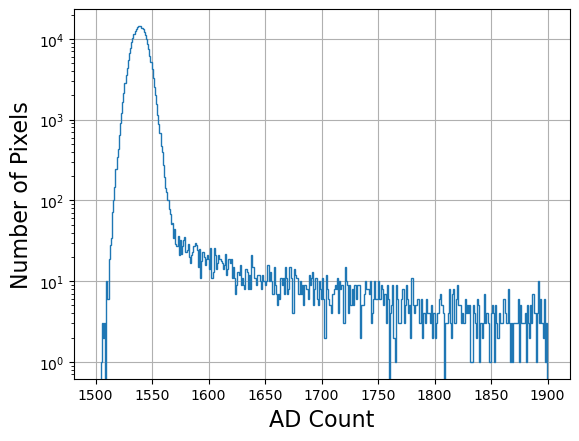

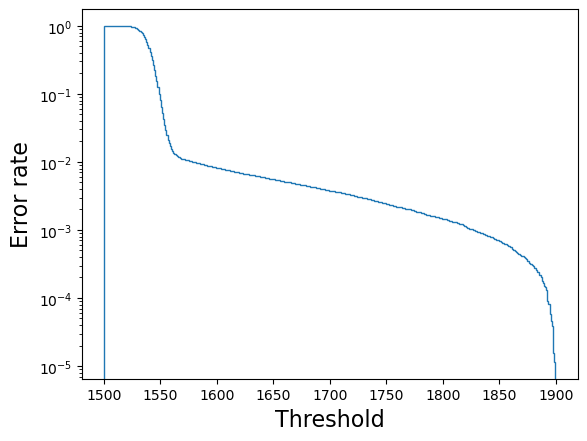

In [9]:
#Load Nuvu data:
file_path = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27\0031\2025-02-27_0031_BaF_Fluorescence_0_rep00300.h5'
with h5py.File(file_path, 'r') as file:
    image_data = file['images/camera/fluorescence/frame'][:]
background_counts = image_data.ravel()

#Plot histogram
plt.figure(1)
background_bins=plt.hist(background_counts,bins=np.arange(1500.5,1900.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# Plot error rate 
plt.figure(2)
plt.hist(background_counts,bins=np.arange(1500.5,1900.5),log=True, histtype='step', density = True, cumulative=-1)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.show()

In [10]:
# np.save('Z:/Imaging/objective_imaging/gain1000_verticalshift17us_readout1MHz.npy',background_counts)

[1.38391232e+00 1.00000000e+01 1.53800000e+03]
[19, 59, 1513, 1565, 1500, 1900]
fit region: AD count =  1520 to  1559
Fit Converged
Converged with chi-squared 116.47045423262256
Number of degrees of freedom, dof = 37
Reduced chi-squared 3.1478501143952045
Inital guess values:
  p0 = [1.3839123160833156, 10, 1538]
Best fit values:
  pf = [0.9827670635455921, 7.144704225365746, 1538.8672189583322]
Uncertainties in the best fit values:
  pferr = [0.001942643543704887, 0.011285238116638816, 0.014445573402479603]


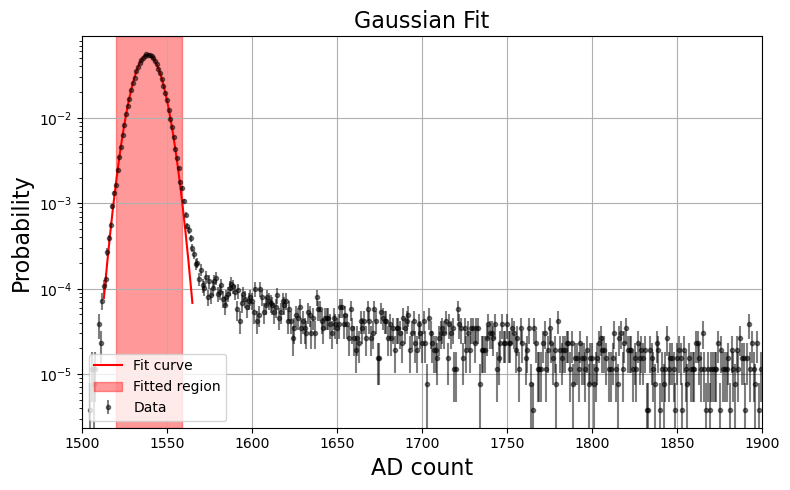

In [11]:
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1560

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +5

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1500
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=10

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))



## Calculate the threshold in two ways
### (1) Nuvu: 5$\sigma$ of the fitted Gaussian
### (2) Loic: Error rate due to dark current = 1e-4

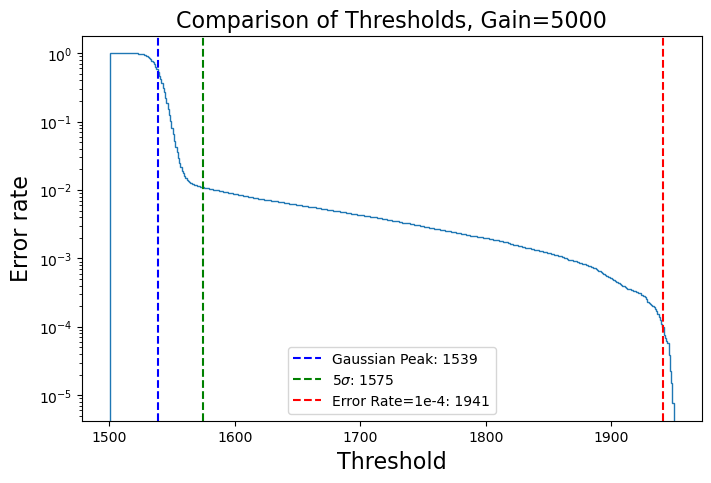

In [12]:
plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(background_counts,bins=np.arange(1500.5,1950.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.grid()
# Find the bin where y reaches 1e-4
threshold = 1e-4
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate the center of each bin

# Look for the first bin where the y-value (count) is <= threshold
for i in range(len(counts)):
    if counts[i] <= threshold:
        x_cross = bin_centers[i]
        break
plt.axvline(x=pf[2], color='b', linestyle='--', label=f'Gaussian Peak: {pf[2]:.0f}') 
plt.axvline(x=pf[2]+pf[1]*5, color='g', linestyle='--', label=f'5$\\sigma$: {pf[2]+pf[1]*5:.0f}') #Nuvu
plt.axvline(x=x_cross, color='r', linestyle='--', label=f'Error Rate=1e-4: {x_cross:.0f}') #Loic

plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('Comparison of Thresholds, Gain=5000', fontsize=16)
plt.legend()
plt.show()

# References 
#### 1000 Gain, 10MHz (Predicted)
serial CIC: 1.73%
parallel CIC: 0.0%
gain: 134
readout noise: 0.2472 electrons

#### 5000 Gain, 10MHz (Predicted)
serial CIC: 1.28%
parallel CIC: -0.07%
gain: 1642
readout noise: 0.0208 electrons

# Now try with averaged 300 photos..
Data used from 02/27/2025, where the probe beam was focused at the center, gain=5000, probe power (712nm) scanned from 0 to 100mW. Let's use data from binning = 1x1

Adjusted from Histogram_02_27_2025.ipynb


In [13]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\02\27'
seq_binning1 = [24, 23, 18, 17, 12] #binning=1x1, order = [100mW, 10mW, 1mW, 0.1mW, 0mW]
labels = [ '100mW', '10mW', '1mW', '0.1mW', '0mW']

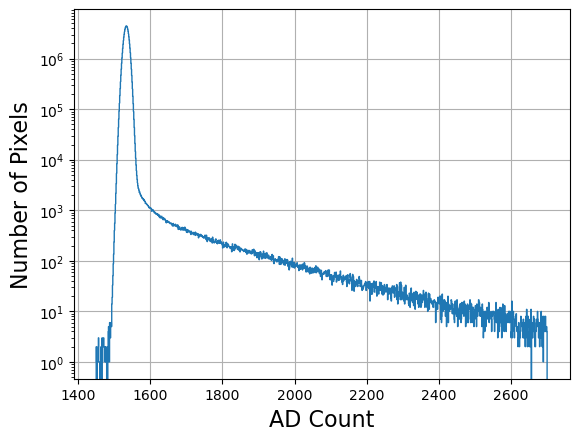

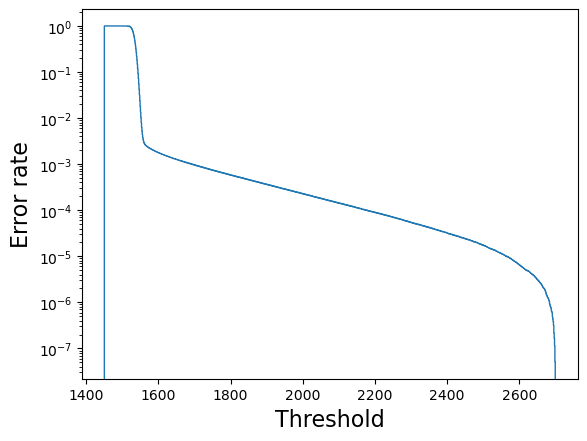

In [16]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\%.4i'%seq_binning1[-1]
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# Plot error rate 
plt.figure(4)
plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.show()

[9.9207746e-01 7.0000000e+00 1.5340000e+03]
[59, 109, 1503, 1565, 1480, 1900]
fit region: AD count =  1510 to  1559
Fit Converged
Converged with chi-squared 24705.998160372365
Number of degrees of freedom, dof = 47
Reduced chi-squared 525.6595353270716
Inital guess values:
  p0 = [0.9920774598950297, 7, 1534]
Best fit values:
  pf = [0.9966551658408338, 7.104992825510186, 1534.031028539417]
Uncertainties in the best fit values:
  pferr = [0.00011260087835868258, 0.0005886209848409743, 0.0008050933014680337]


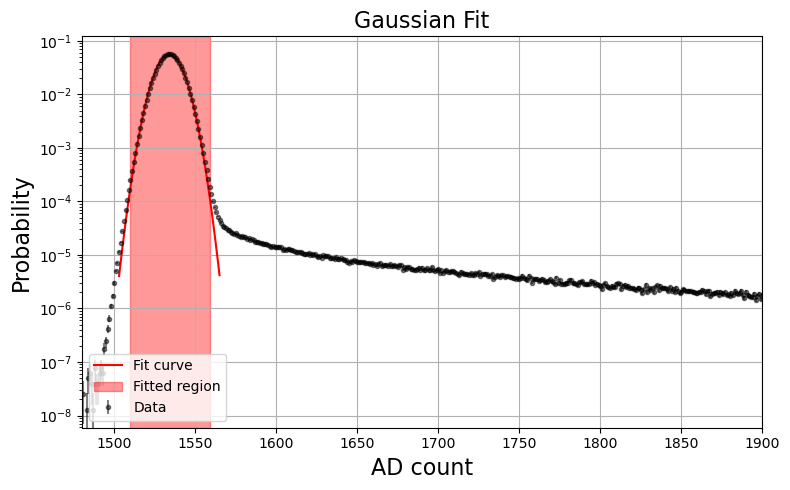

In [18]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1510
End_gaussian=1560

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +5

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))

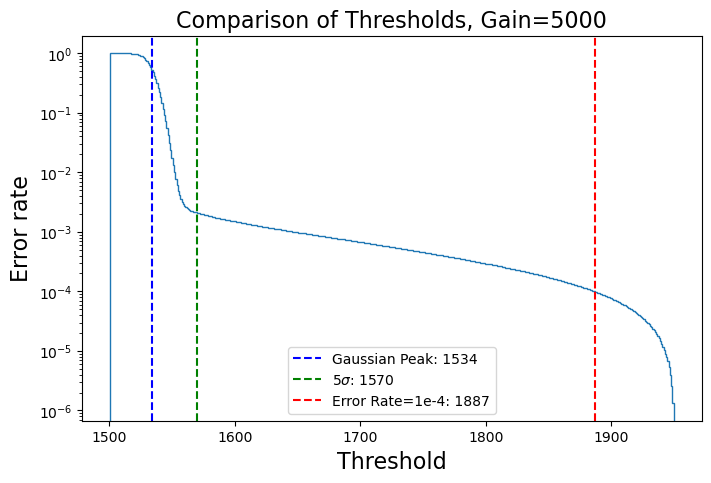

In [19]:
plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(background_counts,bins=np.arange(1500.5,1950.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.grid()
# Find the bin where y reaches 1e-4
threshold = 1e-4
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate the center of each bin

# Look for the first bin where the y-value (count) is <= threshold
for i in range(len(counts)):
    if counts[i] <= threshold:
        x_cross = bin_centers[i]
        break
plt.axvline(x=pf[2], color='b', linestyle='--', label=f'Gaussian Peak: {pf[2]:.0f}') 
plt.axvline(x=pf[2]+pf[1]*5, color='g', linestyle='--', label=f'5$\\sigma$: {pf[2]+pf[1]*5:.0f}') #Nuvu
plt.axvline(x=x_cross, color='r', linestyle='--', label=f'Error Rate=1e-4: {x_cross:.0f}') #Loic

plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('Comparison of Thresholds, Gain=5000', fontsize=16)
plt.legend()
plt.show()

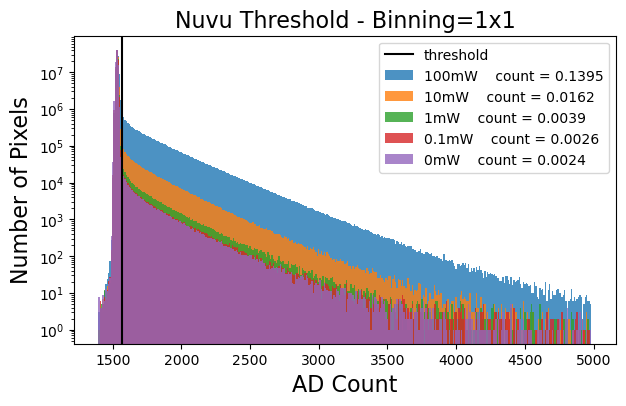

In [22]:
counting_threshold = 1570 #Use Nuvu or Loic 

all_images_binning1 = np.full((len(seq_binning1), 300, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, count_b, :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))

plt.figure(figsize=(7, 4), num = 'histograms')
bins = np.arange(1400, 5000, 10)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha = 0.8, label = labels[i] + '    count = ' + '%.4f'%counts[i])
plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')
plt.title('Nuvu Threshold - Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()